In [16]:
library(tidyverse)
library(caret)
library(Biobase)
library(PharmacoGx)
library(Hmisc)
library(glmnet)
library(mRMRe)
library(SummarizedExperiment)
library(ggplot2)
library(EDASeq)
library(dplyr)
library(ggpubr)
library(gridExtra)
library(RColorBrewer)
library(ggfortify)
library(FactoMineR)
library(factoextra)
library(pheatmap)

In [5]:
options(stringsAsFactors = F)

# Identify Transcript Stability across Biological Replicates

### Read in PSets

In [10]:
gCSI <- readRDS("gCSI.rds")

In [11]:
CCLE <- readRDS("CCLE.rds")

In [12]:
GDSC <- readRDS("GDSC2.rds")

### Read in biological replicates

In [9]:
load("inter.RData") #intersected_rnacells

### SummarizeMolecularProfiles (transcript counts) for biological replicates

In [13]:
gCSI_rna <- summarizeMolecularProfiles(pSet = gCSI, mDataType = "Kallisto_0.46.1.isoforms.counts", cell.lines = intersected_rnacells)
GDSC_rna <- summarizeMolecularProfiles(pSet = GDSC, mDataType = "Kallisto_0.46.1.isoforms.counts", cell.lines = intersected_rnacells)
CCLE_rna <- summarizeMolecularProfiles(pSet = CCLE, mDataType = "Kallisto_0.46.1.isoforms.counts", cell.lines = intersected_rnacells)

Summarizing Kallisto_0.46.1.isoforms.counts molecular data for:	gCSI



  |======================================================================| 100%


Summarizing Kallisto_0.46.1.isoforms.counts molecular data for:	GDSC_v2



  |======================================================================| 100%


### (1) Identify correlation between PSet transcript count

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



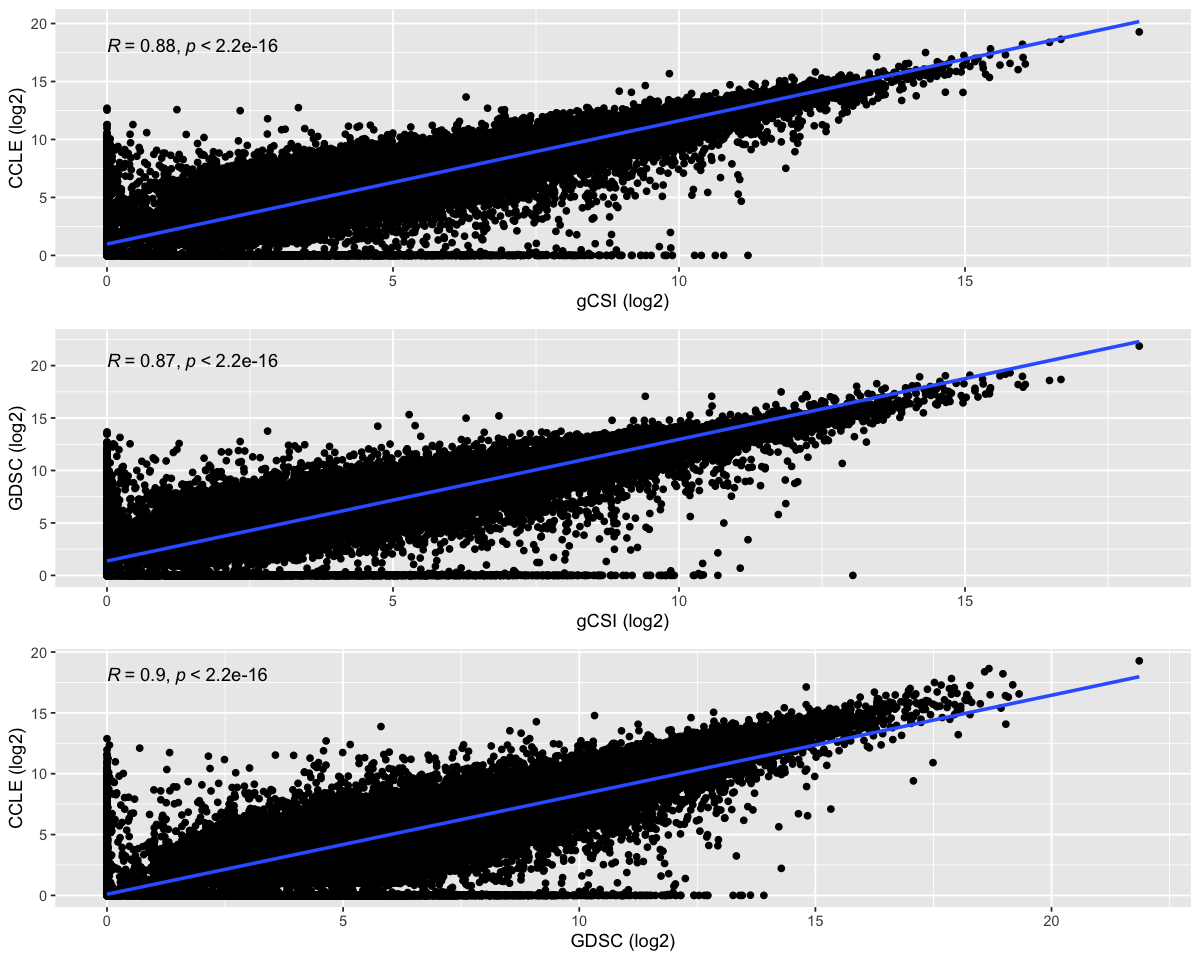

In [27]:
gcsi_ccle <- qplot(as.vector(gCSI_rna@assays@data$exprs)[1:100000], y = as.vector(CCLE_rna@assays@data$exprs)[1:100000], xlab = "gCSI (log2)", ylab = "CCLE (log2)") + geom_smooth(method="lm") + stat_cor(method="pearson")
gcsi_gdsc <- qplot(as.vector(gCSI_rna@assays@data$exprs)[1:100000], y = as.vector(GDSC_rna@assays@data$exprs)[1:100000], xlab = "gCSI (log2)", ylab = "GDSC (log2)") + geom_smooth(method="lm") + stat_cor(method="pearson")
gdsc_ccle <- qplot(as.vector(GDSC_rna@assays@data$exprs)[1:100000], y = as.vector(CCLE_rna@assays@data$exprs)[1:100000], xlab = "GDSC (log2)", ylab = "CCLE (log2)") + geom_smooth(method="lm") + stat_cor(method="pearson")

options(repr.plot.width=10, repr.plot.height=8)
grid.arrange(gcsi_ccle, gcsi_gdsc, gdsc_ccle)

### (2) Heatmap of transcript count across replicates

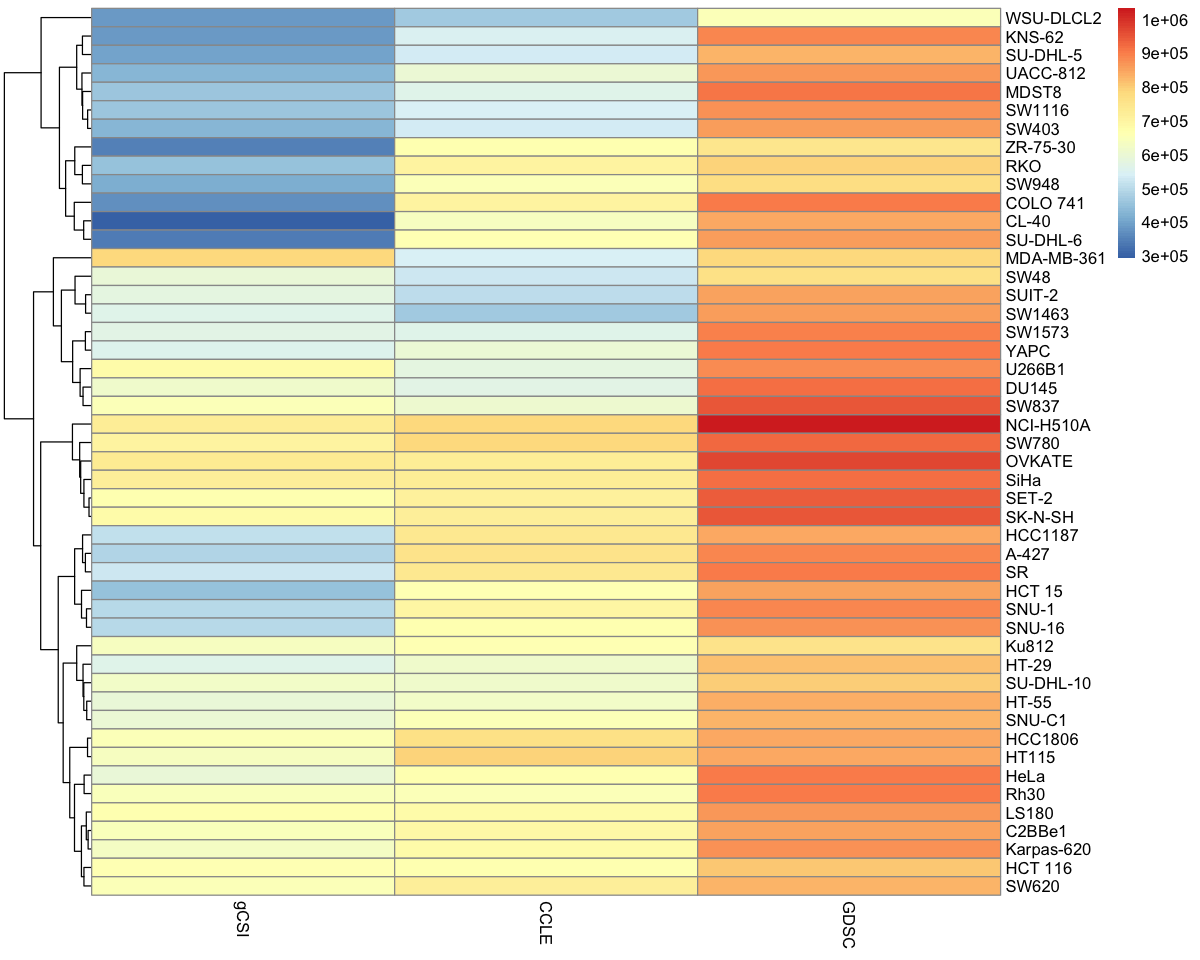

In [26]:
transcript_combined <- data.frame("gcsi"=as.numeric(colSums(gCSI_rna@assays@data$exprs)), 
                            "ccle"=as.numeric(colSums(CCLE_rna@assays@data$exprs)), 
                            "gdsc"=as.numeric(colSums(GDSC_rna@assays@data$exprs))
                            )

rownames(transcript_combined) <- intersected_rnacells
colnames(transcript_combined) <- c("gCSI","CCLE","GDSC")
transcript_combined <- as.matrix(transcript_combined)

options(repr.plot.width=10, repr.plot.height=8)
pheatmap(transcript_combined, cluster_rows=TRUE, show_rownames=TRUE,
         cluster_cols=FALSE)

### (3) Identify sample-to-sample relationships (PCA)

In [24]:
gcsi_m <- as.data.frame(gCSI_rna@assays@data$exprs)
ccle_m <- as.data.frame(CCLE_rna@assays@data$exprs)
gdsc_m <- as.data.frame(GDSC_rna@assays@data$exprs)

colnames(gcsi_m) <- paste0("gcsi_", colnames(gcsi_m))
colnames(ccle_m) <- paste0("ccle_", colnames(ccle_m))
colnames(gdsc_m) <- paste0("gdsc_", colnames(gdsc_m))

combined_m <- as.data.frame(as.matrix(t(cbind.data.frame(gcsi_m,ccle_m,gdsc_m))))
combined_m <- combined_m
combined_m$dataset <- NA
combined_m$dataset[1:48] <- 'gCSI'
combined_m$dataset[49:96] <- 'CCLE'
combined_m$dataset[97:144] <- 'GDSC'

tt <- PCA(combined_m[,-227913], graph = FALSE)

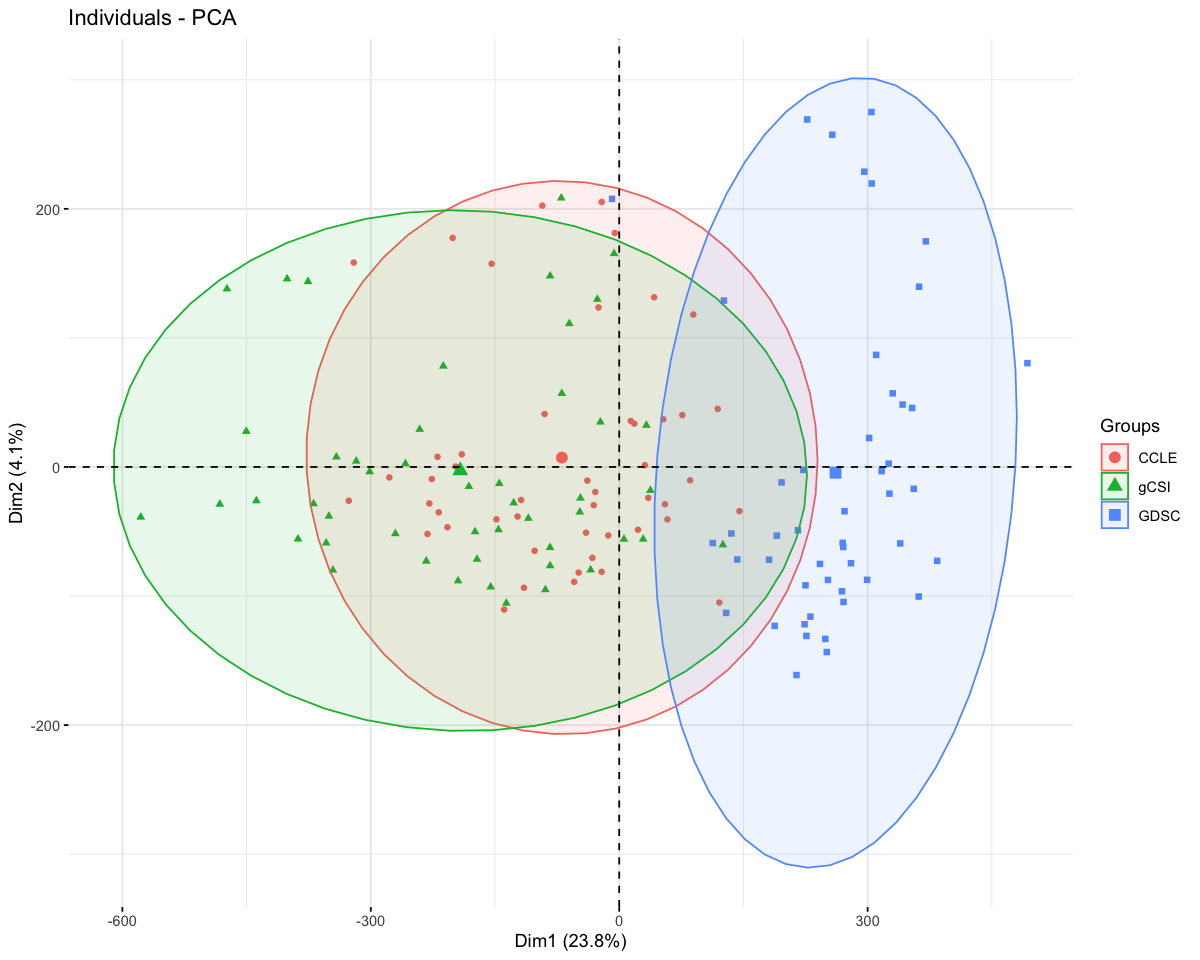

In [25]:
options(repr.plot.width=10, repr.plot.height=8)
fviz_pca_ind(tt,
             geom.ind = "point", # show points only (but not "text")
             col.ind = combined_m$dataset, # color by groups
             addEllipses = TRUE, # Concentration ellipses
             legend.title = "Groups"
)

# Create ML model to predict transcript stability

### Extract gene expression matrix from PSets

In [109]:
#genes as rows, cell lines as columns
expr <- as.data.frame(assay(summarizeMolecularProfiles(gCSI, mDataType = "Kallisto_0.46.1.rnaseq", 
                                                       fill.missing = FALSE)))

Summarizing Kallisto_0.46.1.rnaseq molecular data for:	gCSI



  |======================================================================| 100%


### Extract feature data from Ensembl

#### %GC content + gene length

In [110]:
#use EDAseq package for retrieving %GC content & gene length from Ensembl GeneID
expr_features <- gCSI@molecularProfiles$Kallisto_0.46.1.rnaseq@elementMetadata
expr_features$gene_id_stable <- gsub("\\..*","",expr_features$gene_id)
#length_gc <- getGeneLengthAndGCContent(expr_features$gene_id_stable, "hsa") #this takes about 30-40 min
load("ensembl_length_gc.RData") #loads in length_gc

#### miRNA binding sites

In [111]:
#miRNA binding sites
ensembl_features_miRNA <- read.csv("ensembl_hg38_features_miRNA.txt", sep = "\t") #miRNA bindings to gene

#get total # of miRNA binding sites per gene
mirna_total <- ensembl_features_miRNA %>% 
  group_by(Ensembl.gene.ID) %>% 
  summarise(miRNA.identifier = n_distinct(miRNA.identifier))

`summarise()` ungrouping output (override with `.groups` argument)



#### Exon number

In [112]:
#exon number
ensembl_features_exon <- read.csv("ensembl_hg38_features_exon.txt")

#get total # of exons per gene
exon_total <- ensembl_features_exon %>% 
  group_by(ensembl_features_exon$Gene.stable.ID.version) %>% 
  summarise(Exon.stable.ID = n_distinct(Exon.stable.ID))

`summarise()` ungrouping output (override with `.groups` argument)



#### Transcript count

In [113]:
ensembl_features_transcript <- read.csv("ensembl_hg38_features.txt")

### Assign Ensembl feature data to expression matrix

In [114]:
#expr$type <- expr_features$transcript_type # transcript type (e.g. lncRNA)
#expr <- transform(expr,type_id=as.numeric(factor(type))) #assign numerial to each unique type (for training model)

expr$gc <- as.vector(length_gc[,1])
expr$length <- as.vector(length_gc[,2])
expr$exon <- exon_total$Exon.stable.ID[match(rownames(expr),exon_total$`ensembl_features_exon$Gene.stable.ID.version`)]
expr$t_count <- ensembl_features_transcript$Transcript.count[match(rownames(expr), ensembl_features_transcript$Gene.stable.ID.version)]

### Assign MEAN of feature for any NAs

In [115]:
#miRNA binding site count
#expr_features <- expr_features[match(mirna_total$Ensembl.gene.ID,expr_features$gene_id_stable),]
#expr <- expr[match(mirna_total$Ensembl.gene.ID,expr_features$gene_id_stable),] #only 14,000/60,000 kept
#expr$mirna <- mirna_total$miRNA.identifier[match(expr_features$gene_id_stable,mirna_total$Ensembl.gene.ID)]
#mean_mirna <- mean(expr$mirna[which(!is.na(expr$mirna))])
#expr$mirna[which(is.na(expr$mirna))] <- mean_mirna

#%GC content
mean_gc <- mean(expr$gc[which(!is.na(expr$gc))])
expr$gc[which(is.na(expr$gc))] <- mean_gc

#Gene length
mean_length <- mean(expr$length[which(!is.na(expr$length))])
expr$length[which(is.na(expr$length))] <- mean_length

#Exon number
mean_exon <- mean(expr$exon[which(!is.na(expr$exon))])
expr$exon[which(is.na(expr$exon))] <- mean_exon

#Transcript number
mean_transcript <- mean(expr$t_count[which(!is.na(expr$t_count))])
expr$t_count[which(is.na(expr$t_count))] <- mean_transcript

### Plot feature distribution (expression)

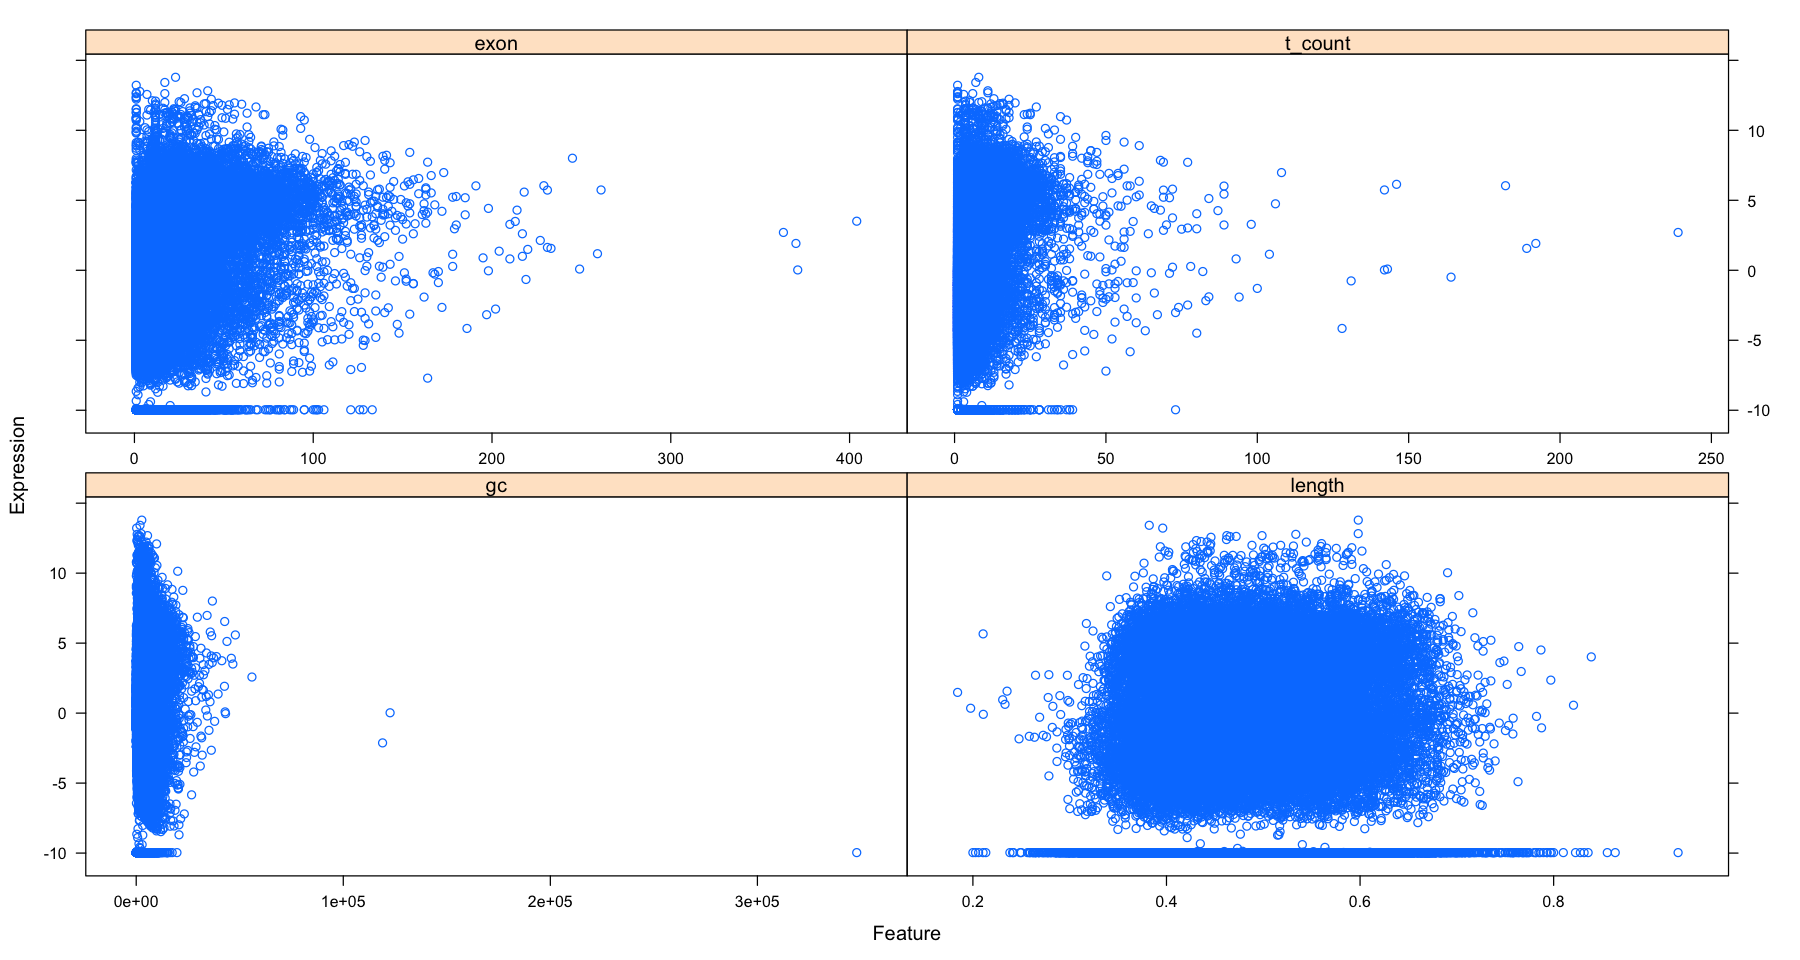

In [117]:
#use one cell line as example
expr_sub <- expr[1:50000, ]
options(repr.plot.width=15, repr.plot.height=8)
featurePlot(x = expr_sub[ , c("gc","length","exon","t_count")], y = expr_sub$HCC827, labels = c("Feature", "Expression"))

# 1. <u>Elastic Net with K-fold cross validation</u>

In [68]:
set.seed(123)

### Use small sample of matrix for testing (n=10,000)

In [118]:
exprs_sub <- expr[,c(500,673,674,675,676)]
colnames(exprs_sub)[1] <- "gene_exprs"
head(exprs_sub)

#Gene expression remove NA's
#mean_exp <- mean(exprs_sub$gene_exprs[which(!is.na(exprs_sub$gene_exprs))])
#exprs_sub$gene_exprs[which(is.na(exprs_sub$gene_exprs))] <- mean_exp

,gene_exprs,gc,length,exon,t_count
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000000003.15,4.518594,4536,0.3992504,20,5
ENSG00000000005.6,-5.667198,1476,0.4241192,10,2
ENSG00000000419.12,6.641507,1207,0.4159072,27,6
ENSG00000000457.14,2.172483,6883,0.4117391,30,5
ENSG00000000460.17,4.001964,5970,0.4298157,70,9
ENSG00000000938.13,-3.436078,3382,0.5644589,24,7


### Train model

In [119]:
transcript_model <- train(
  gene_exprs ~., #y-values (trying one sample)
  data=exprs_sub, #df with rows as samples and columns as features
  method = "glmnet",
  trControl = trainControl(
    method = "cv", 
    number = 10,
    verboseIter = TRUE
  )
)

+ Fold01: alpha=0.10, lambda=0.6012 
- Fold01: alpha=0.10, lambda=0.6012 
+ Fold01: alpha=0.55, lambda=0.6012 
- Fold01: alpha=0.55, lambda=0.6012 
+ Fold01: alpha=1.00, lambda=0.6012 
- Fold01: alpha=1.00, lambda=0.6012 
+ Fold02: alpha=0.10, lambda=0.6012 
- Fold02: alpha=0.10, lambda=0.6012 
+ Fold02: alpha=0.55, lambda=0.6012 
- Fold02: alpha=0.55, lambda=0.6012 
+ Fold02: alpha=1.00, lambda=0.6012 
- Fold02: alpha=1.00, lambda=0.6012 
+ Fold03: alpha=0.10, lambda=0.6012 
- Fold03: alpha=0.10, lambda=0.6012 
+ Fold03: alpha=0.55, lambda=0.6012 
- Fold03: alpha=0.55, lambda=0.6012 
+ Fold03: alpha=1.00, lambda=0.6012 
- Fold03: alpha=1.00, lambda=0.6012 
+ Fold04: alpha=0.10, lambda=0.6012 
- Fold04: alpha=0.10, lambda=0.6012 
+ Fold04: alpha=0.55, lambda=0.6012 
- Fold04: alpha=0.55, lambda=0.6012 
+ Fold04: alpha=1.00, lambda=0.6012 
- Fold04: alpha=1.00, lambda=0.6012 
+ Fold05: alpha=0.10, lambda=0.6012 
- Fold05: alpha=0.10, lambda=0.6012 
+ Fold05: alpha=0.55, lambda=0.6012 
-

In [120]:
transcript_model

glmnet 

60662 samples
    4 predictor

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 54595, 54596, 54597, 54597, 54596, 54595, ... 
Resampling results across tuning parameters:

  alpha  lambda       RMSE      Rsquared   MAE     
  0.10   0.006012113  4.888352  0.3022384  4.223264
  0.10   0.060121126  4.888265  0.3022774  4.224555
  0.10   0.601211261  4.893501  0.3018118  4.252964
  0.55   0.006012113  4.888378  0.3022021  4.224468
  0.55   0.060121126  4.888361  0.3021808  4.228985
  0.55   0.601211261  4.916067  0.2995261  4.304815
  1.00   0.006012113  4.888392  0.3021761  4.224442
  1.00   0.060121126  4.888654  0.3020571  4.233518
  1.00   0.601211261  4.964574  0.2910341  4.369607

RMSE was used to select the optimal model using the smallest value.
The final values used for the model were alpha = 0.1 and lambda = 0.06012113.